In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# List all files in the current directory
dir = '../data.lbm/fixedParticle_closer/'
# os.listdir(dir)

# Partícula

In [4]:
particleDf = pd.read_csv(dir+"particlesTrj.csv")
particleDf

,tick,time,particleId,position_x,position_y,velocity_x,velocity_y,angularVelocity
0,0,0.000000,1,0.0,0.0,0.0,0.0,0.01
1,10,0.080160,1,0.0,0.0,0.0,0.0,0.01
2,20,0.160321,1,0.0,0.0,0.0,0.0,0.01
3,30,0.240481,1,0.0,0.0,0.0,0.0,0.01
4,40,0.320641,1,0.0,0.0,0.0,0.0,0.01
...,...,...,...,...,...,...,...,...
744,7440,59.639279,1,0.0,0.0,0.0,0.0,0.01
745,7450,59.719439,1,0.0,0.0,0.0,0.0,0.01
746,7460,59.799599,1,0.0,0.0,0.0,0.0,0.01
747,7470,59.879760,1,0.0,0.0,0.0,0.0,0.01


# Fluido

In [5]:
tick = particleDf.tick.values[-1]
fluidDf = pd.read_csv(dir + f"fluidTrj_{tick}.csv").set_index(["id_x","id_y"]).sort_index()

fluidDf

tick      time  coordinate_x  coordinate_y  massDensity  \
id_x id_y                                                            
1    1     7480  59.95992          -2.0     -2.000000          0.0   
     2     7480  59.95992          -2.0     -1.991984          0.0   
     3     7480  59.95992          -2.0     -1.983968          0.0   
     4     7480  59.95992          -2.0     -1.975952          0.0   
     5     7480  59.95992          -2.0     -1.967936          0.0   
...         ...       ...           ...           ...          ...   
500  496   7480  59.95992           2.0      1.967936          0.0   
     497   7480  59.95992           2.0      1.975952          0.0   
     498   7480  59.95992           2.0      1.983968          0.0   
     499   7480  59.95992           2.0      1.991984          0.0   
     500   7480  59.95992           2.0      2.000000          0.0   

           fluidVelocity_x  fluidVelocity_y   f1   f2   f3   f4   f5   f6  \
id_x id_y                                                                   
1    1                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     2                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     3                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     4                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     5                 0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                    ...              ...  ...  ...  ...  ...  ...  ...   
500  496               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     497               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     498               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     499               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   
     500               0.0              0.0  0.0  0.0  0.0  0.0  0.0  0.0   

            f7   f8   f9  
id_x id_y                 
1    1     0.0  0.0  0.0  
     2     0.0  0.0  0.0  
     3     0.0  0.0  0.0  
     4     0.0  0.0  0.0  
     5     0.0  0.0  0.0  
...        ...  ...  ...  
500  496   0.0  0.0  0.0  
     497   0.0  0.0  0.0  
     498   0.0  0.0  0.0  
     499   0.0  0.0  0.0  
     500   0.0  0.0  0.0  

[250000 rows x 16 columns]

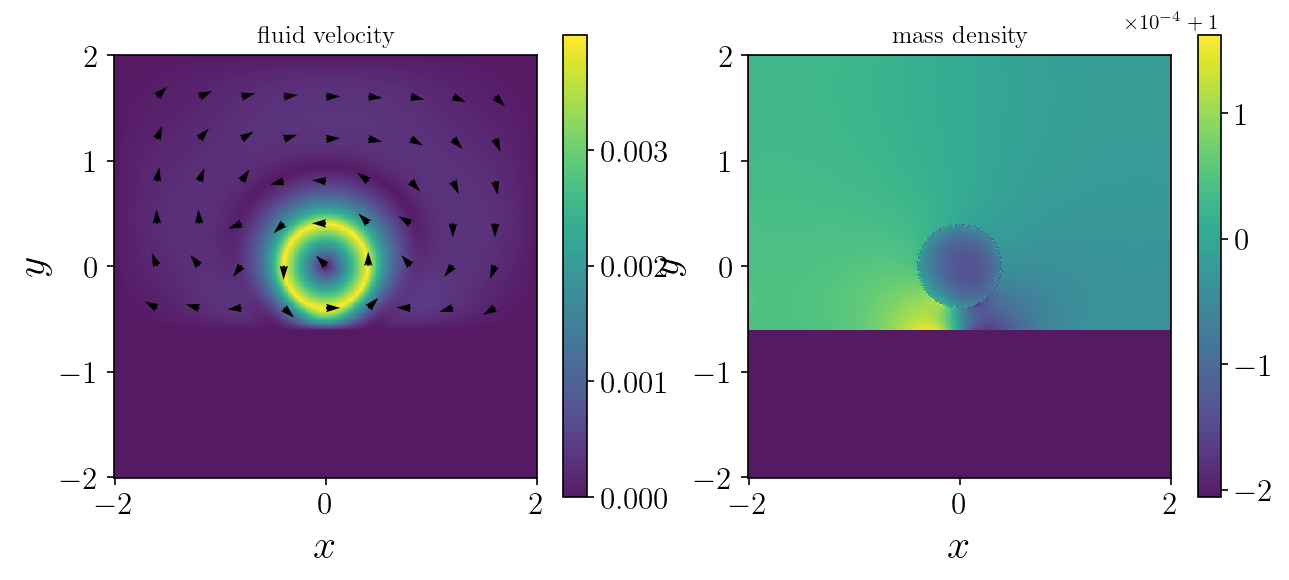

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

maskStep = int(len(x_unique)/10)
# Create a mask for filtering
mask = (fluidDf['coordinate_x'].isin(x_unique[::maskStep])) & (fluidDf['coordinate_y'].isin(y_unique[::maskStep])) & (
    (fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2 > 1e-10)
)
# Filter the DataFrame
filtered_df = fluidDf[mask]

axes[0].quiver(
    filtered_df['coordinate_x'], 
    filtered_df['coordinate_y'], 
    (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    scale = 30,
)

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 1e-2").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(2):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

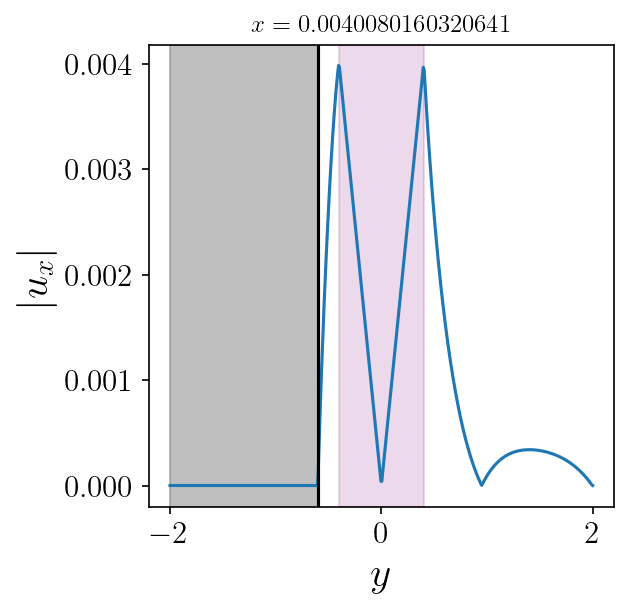

In [7]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a cero
id = fluidDf.query("coordinate_x >= 0").reset_index().iloc[0].filter(["id_x"]).values[0]

# ploteo v_x(y, x = 0)
v_x = fluidDf.loc[id].filter(["coordinate_y", "fluidVelocity_x"])

wallPosition = -0.6

plt.plot(v_x.coordinate_y, abs(v_x.fluidVelocity_x)) 
plt.xlabel("$y$")
plt.ylabel("$|u_x|$")
plt.title(f"$x = {fluidDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$")
plt.axvline(wallPosition, color = "k")
plt.axvspan(-2, wallPosition, color='gray', alpha=0.5)  # Shade the wall
plt.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

plt.show()

# Tensor de estrés

In [8]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

tick  time  coordinate_x  coordinate_y  component_xx  component_yx  \
id_x id_y                                                                       
1    1     7485  60.0          -2.0     -2.000000          -0.0          -0.0   
     2     7485  60.0          -2.0     -1.991984          -0.0          -0.0   
     3     7485  60.0          -2.0     -1.983968          -0.0          -0.0   
     4     7485  60.0          -2.0     -1.975952          -0.0          -0.0   
     5     7485  60.0          -2.0     -1.967936          -0.0          -0.0   
...         ...   ...           ...           ...           ...           ...   
500  496   7485  60.0           2.0      1.967936          -0.0          -0.0   
     497   7485  60.0           2.0      1.975952          -0.0          -0.0   
     498   7485  60.0           2.0      1.983968          -0.0          -0.0   
     499   7485  60.0           2.0      1.991984          -0.0          -0.0   
     500   7485  60.0           2.0      2.000000          -0.0          -0.0   

           component_xy  component_yy  
id_x id_y                              
1    1             -0.0          -0.0  
     2             -0.0          -0.0  
     3             -0.0          -0.0  
     4             -0.0          -0.0  
     5             -0.0          -0.0  
...                 ...           ...  
500  496           -0.0          -0.0  
     497           -0.0          -0.0  
     498           -0.0          -0.0  
     499           -0.0          -0.0  
     500           -0.0          -0.0  

[250000 rows x 8 columns]

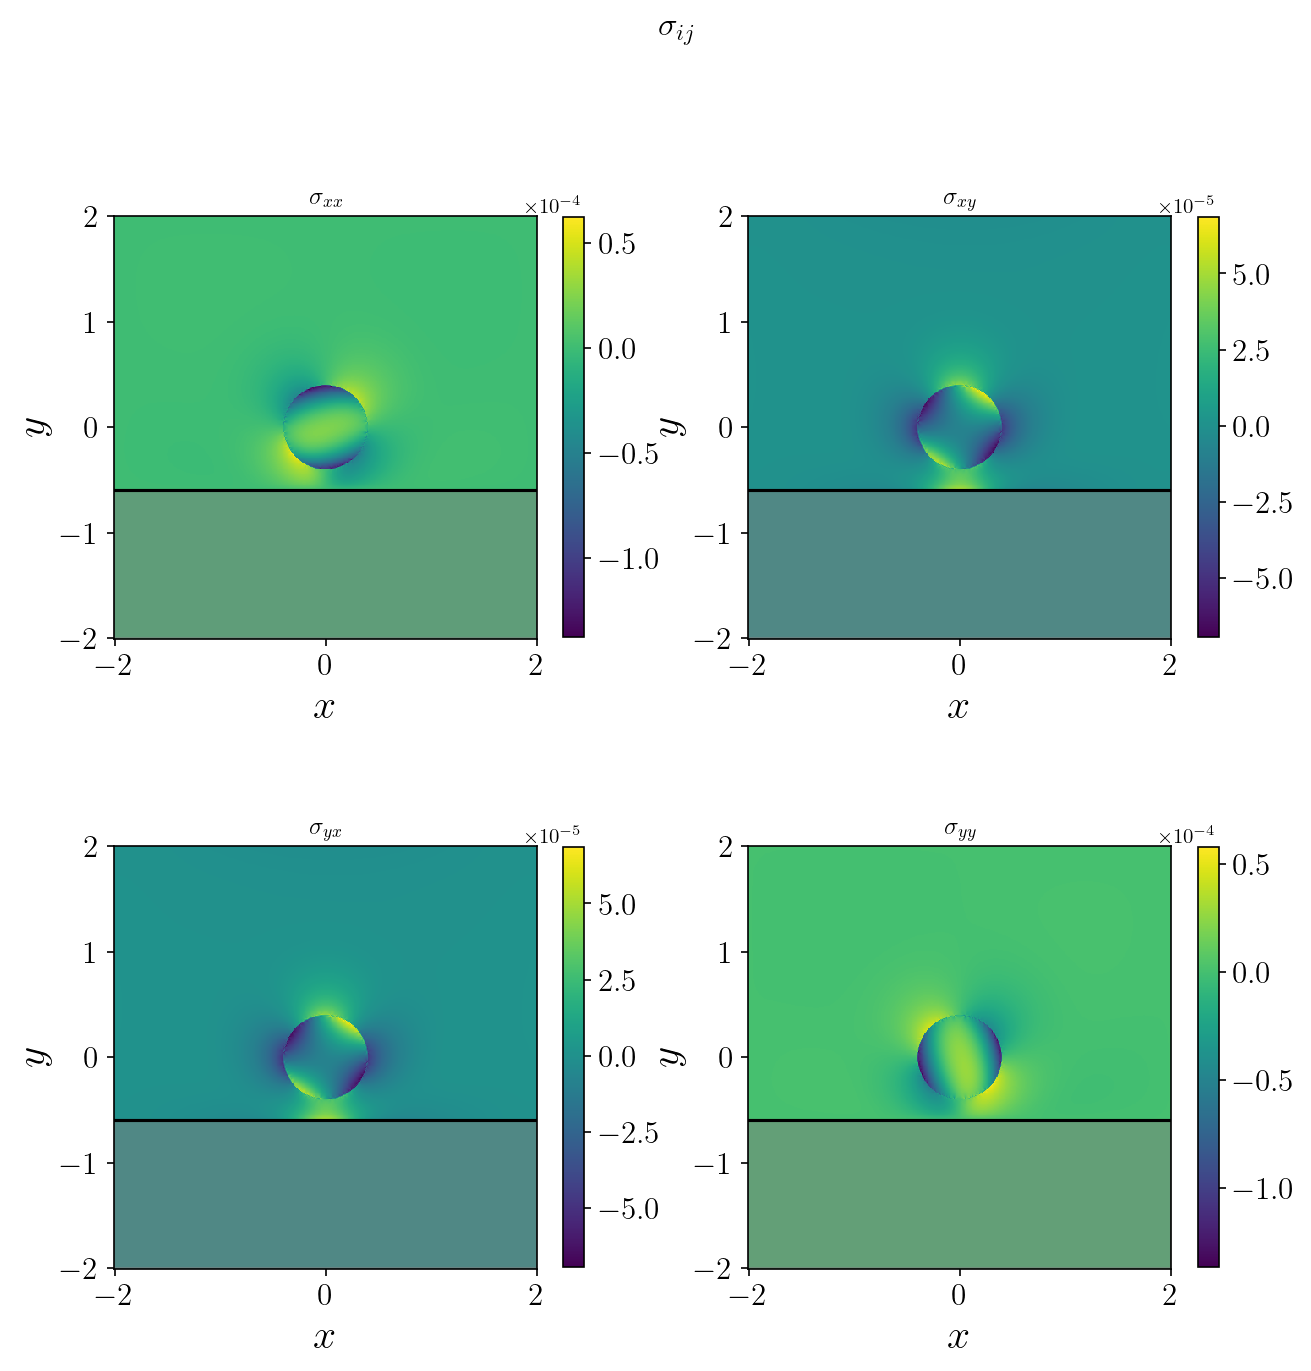

In [9]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
    ax.axhline(wallPosition, color = "k")
    ax.axhspan(-2, wallPosition, color='gray', alpha=0.5)  # Shade the wall

plt.show()

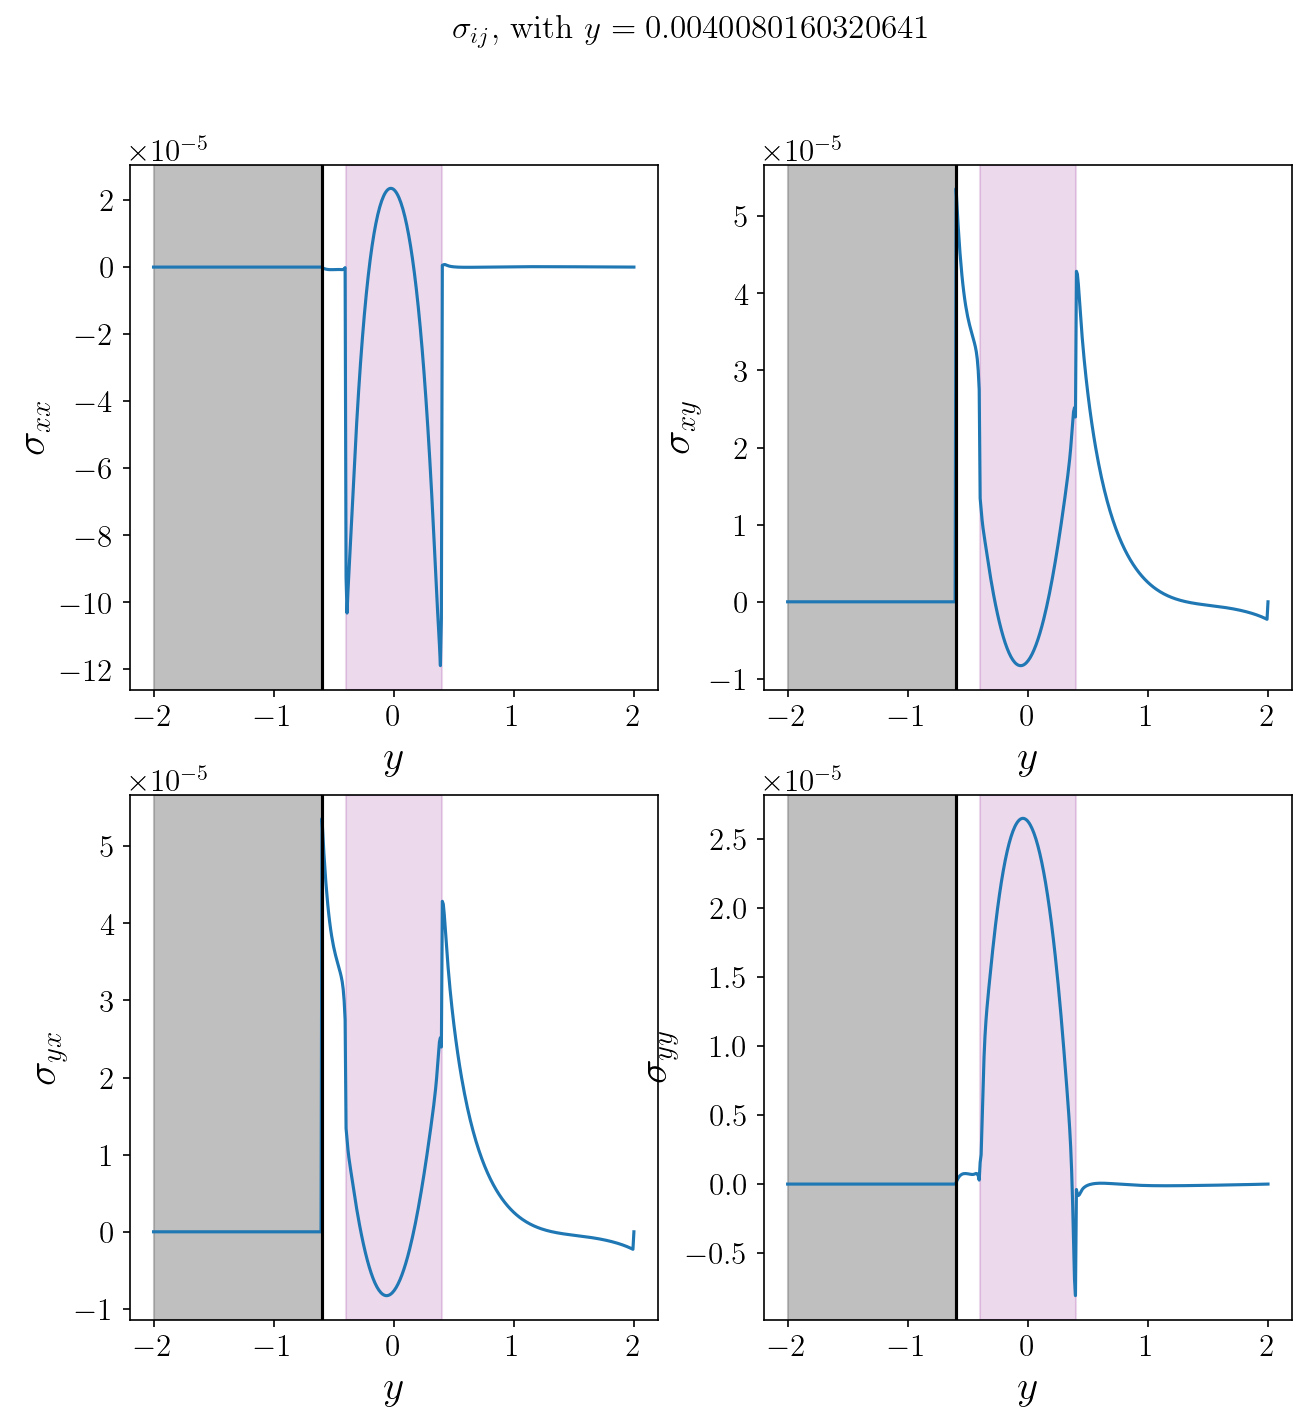

In [10]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a cero
id = stressDf.query("coordinate_x >= 0").reset_index().iloc[0].filter(["id_x"]).values[0]

# ploteo v_x(y, x = 0)
sigma_x = stressDf.loc[id].filter(["coordinate_y", "component_xx", "component_xy", "component_yx", "component_yy"])


# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$, with " f"$y = {stressDf.query(f"id_x == {id}").iloc[0].filter(["coordinate_x"]).values[0]}$", fontsize=16)

axes[0,0].plot(sigma_x.coordinate_y, sigma_x.component_xx) 
axes[0,0].set_ylabel("$\\sigma_{xx}$")    
axes[0,1].plot(sigma_x.coordinate_y, sigma_x.component_xy) 
axes[0,1].set_ylabel("$\\sigma_{xy}$")    
axes[1,0].plot(sigma_x.coordinate_y, sigma_x.component_yx) 
axes[1,0].set_ylabel("$\\sigma_{yx}$")    
axes[1,1].plot(sigma_x.coordinate_y, sigma_x.component_yy) 
axes[1,1].set_ylabel("$\\sigma_{yy}$")    

for ax in axes.flatten():
    ax.set_xlabel("$y$")
    ax.yaxis.set_major_formatter(formatter)
    ax.axvline(wallPosition, color = "k")
    ax.axvspan(-2, wallPosition, color='gray', alpha=0.5)  # Shade the wall
    ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

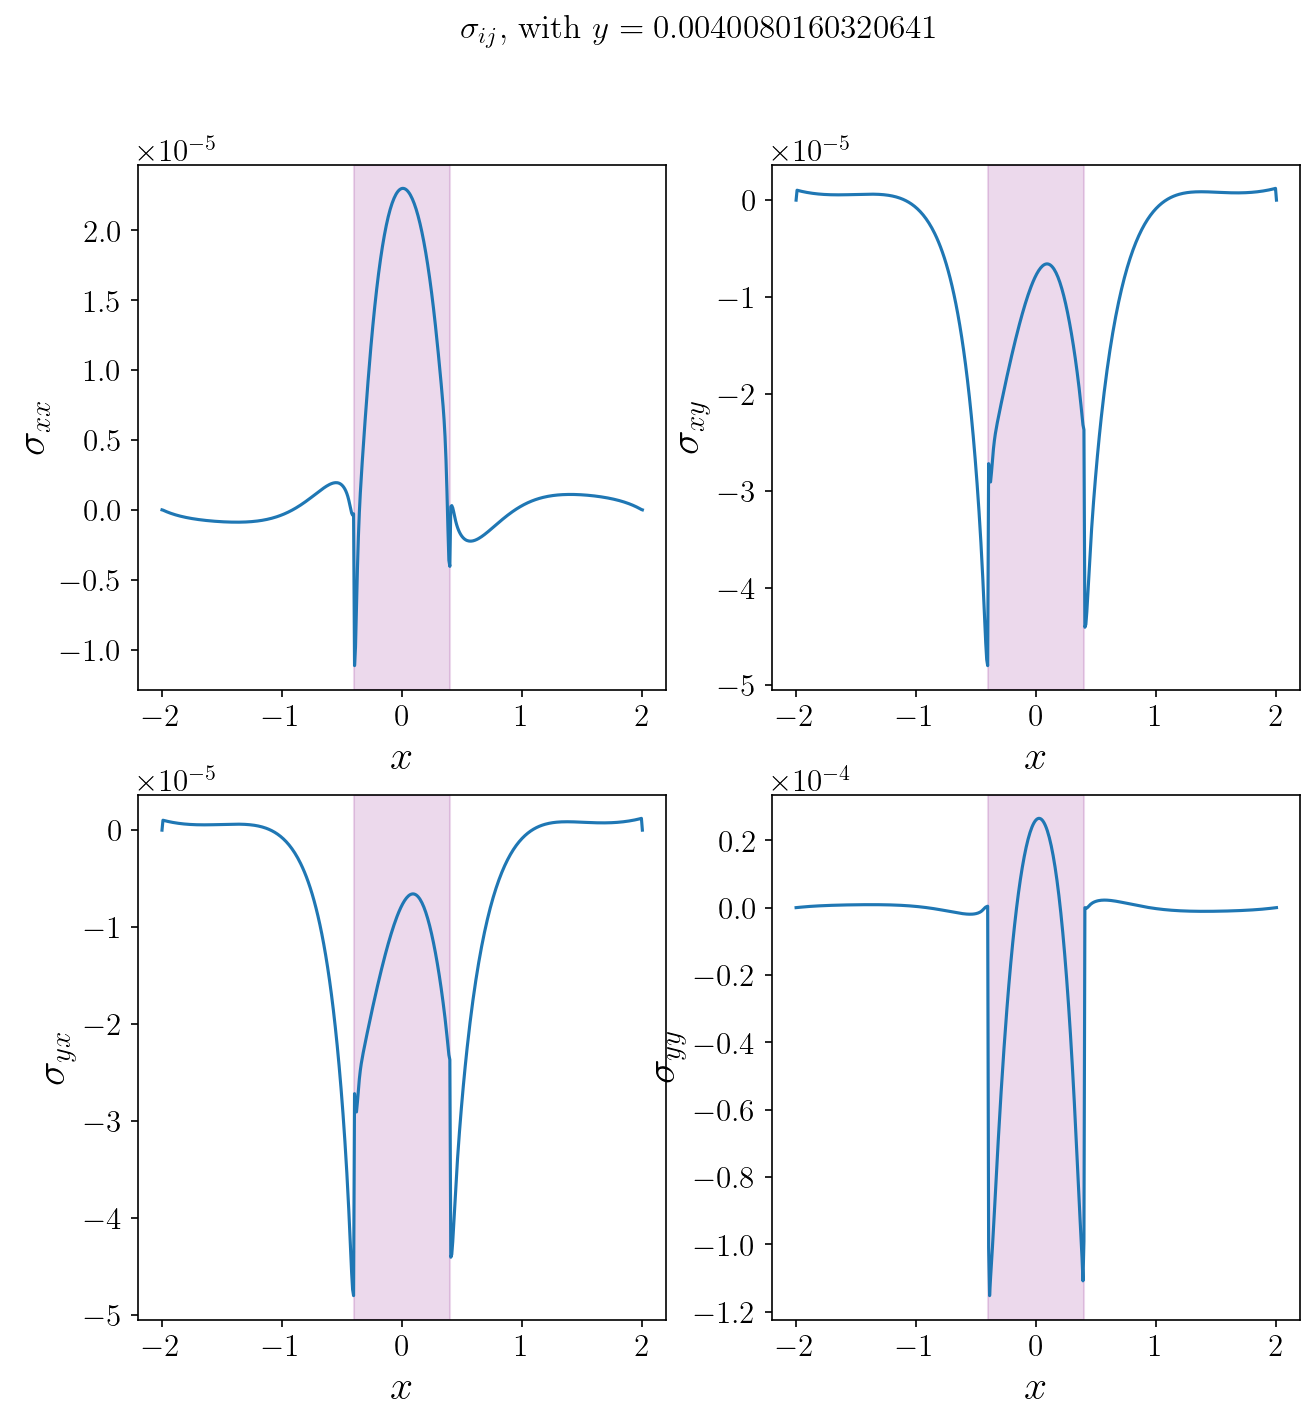

In [11]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a cero
id = stressDf.query("coordinate_y >= 0").reset_index().iloc[0].filter(["id_y"]).values[0]

sigma_y = stressDf.query(f"id_y == {id}").filter(["coordinate_x", "component_xx", "component_xy", "component_yx", "component_yy"])


# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$, with " f"$y = {stressDf.query(f"id_y == {id}").iloc[0].filter(["coordinate_y"]).values[0]}$", fontsize=16)

axes[0,0].plot(sigma_y.coordinate_x, sigma_y.component_xx) 
axes[0,0].set_ylabel("$\\sigma_{xx}$")    
axes[0,1].plot(sigma_y.coordinate_x, sigma_y.component_xy) 
axes[0,1].set_ylabel("$\\sigma_{xy}$")    
axes[1,0].plot(sigma_y.coordinate_x, sigma_y.component_yx) 
axes[1,0].set_ylabel("$\\sigma_{yx}$")    
axes[1,1].plot(sigma_y.coordinate_x, sigma_y.component_yy) 
axes[1,1].set_ylabel("$\\sigma_{yy}$")    

for ax in axes.flatten():
    ax.set_xlabel("$x$")
    ax.yaxis.set_major_formatter(formatter)
    ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

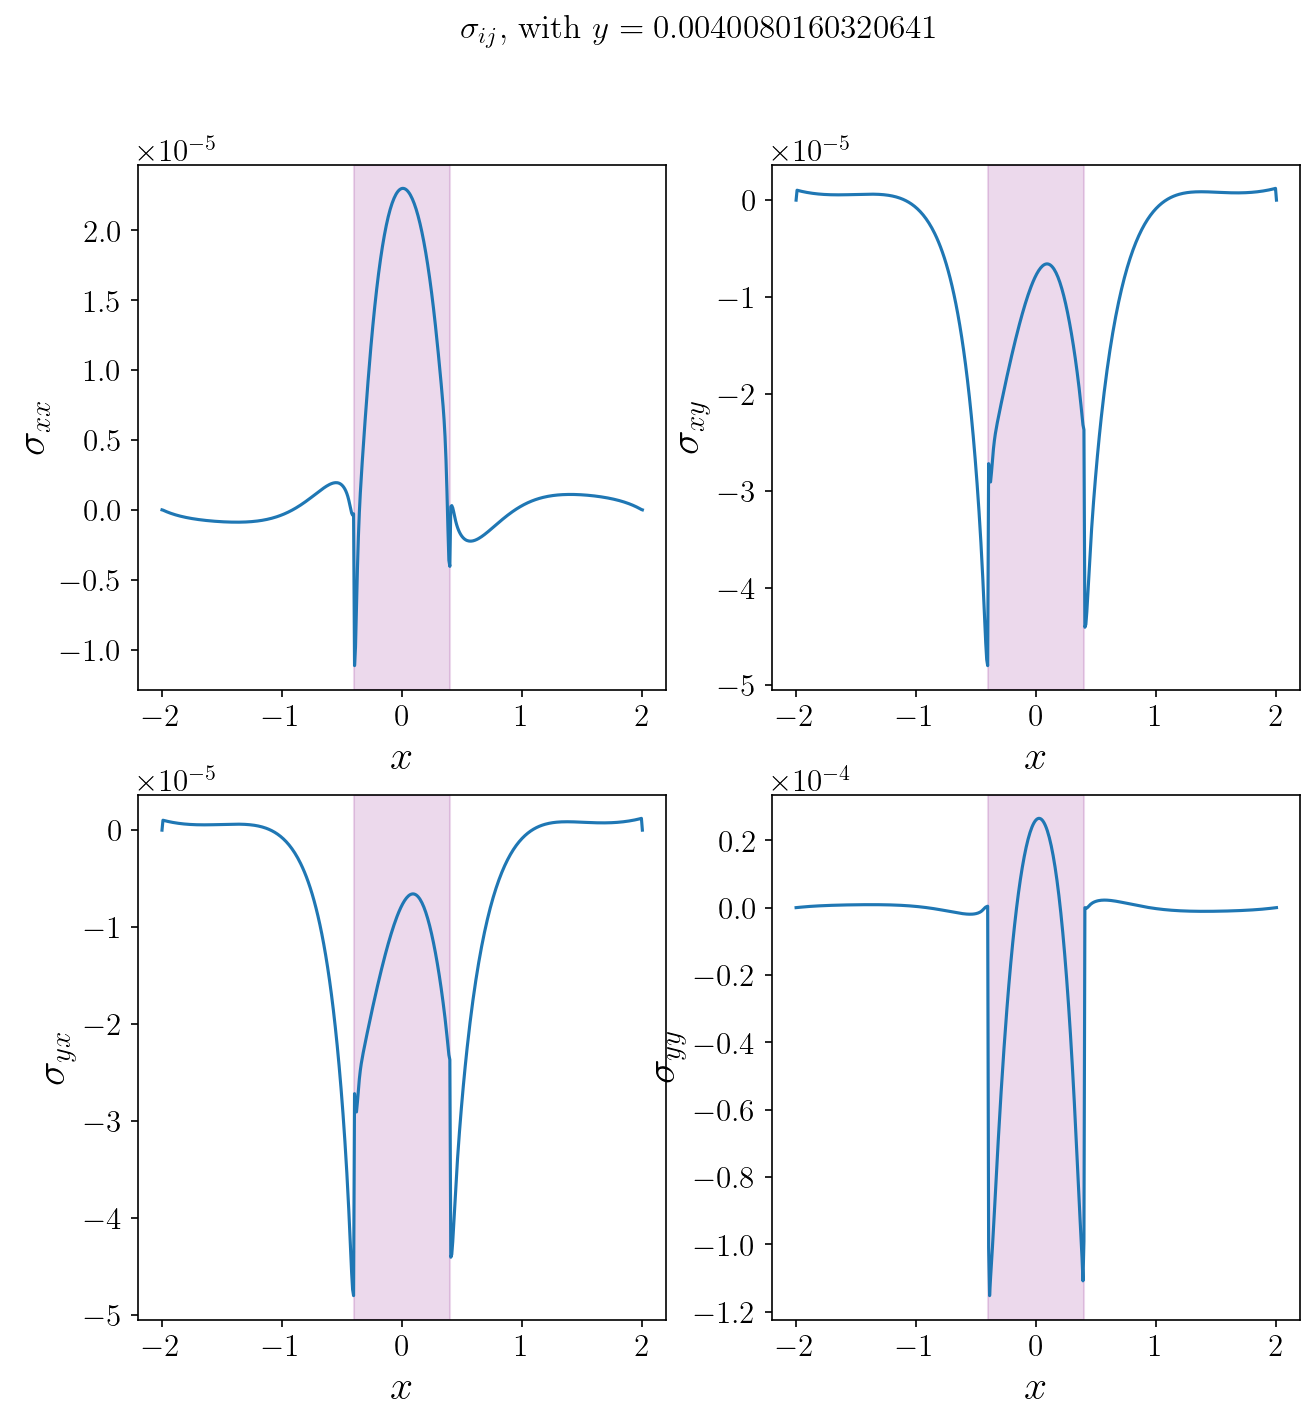

In [12]:
# encuentro el primer id_x tal que coordinate_x sea mayor o igual a cero
id = stressDf.query("coordinate_y >= 0").reset_index().iloc[0].filter(["id_y"]).values[0]

sigma_y = stressDf.query(f"id_y == {id}").filter(["coordinate_x", "component_xx", "component_xy", "component_yx", "component_yy"])


# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$, with " f"$y = {stressDf.query(f"id_y == {id}").iloc[0].filter(["coordinate_y"]).values[0]}$", fontsize=16)

axes[0,0].plot(sigma_y.coordinate_x, sigma_y.component_xx) 
axes[0,0].set_ylabel("$\\sigma_{xx}$")    
axes[0,1].plot(sigma_y.coordinate_x, sigma_y.component_xy) 
axes[0,1].set_ylabel("$\\sigma_{xy}$")    
axes[1,0].plot(sigma_y.coordinate_x, sigma_y.component_yx) 
axes[1,0].set_ylabel("$\\sigma_{yx}$")    
axes[1,1].plot(sigma_y.coordinate_x, sigma_y.component_yy) 
axes[1,1].set_ylabel("$\\sigma_{yy}$")    

for ax in axes.flatten():
    ax.set_xlabel("$x$")
    ax.yaxis.set_major_formatter(formatter)
    ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

In [13]:
# Create points on the unit circle
radius = 0.4
theta = np.linspace(0, 2*np.pi, 1000)  # 1000 points around the circle
circle_x = radius * np.cos(theta)
circle_y = radius * np.sin(theta)

# Use a k-d tree to find the nearest vector field data points for each circle point
# tree = cKDTree(stressDf[['coordinate_x', 'coordinate_y']].values)
tree = cKDTree(fluidDf[['coordinate_x', 'coordinate_y']].values)
_, idx = tree.query(np.c_[circle_x, circle_y])

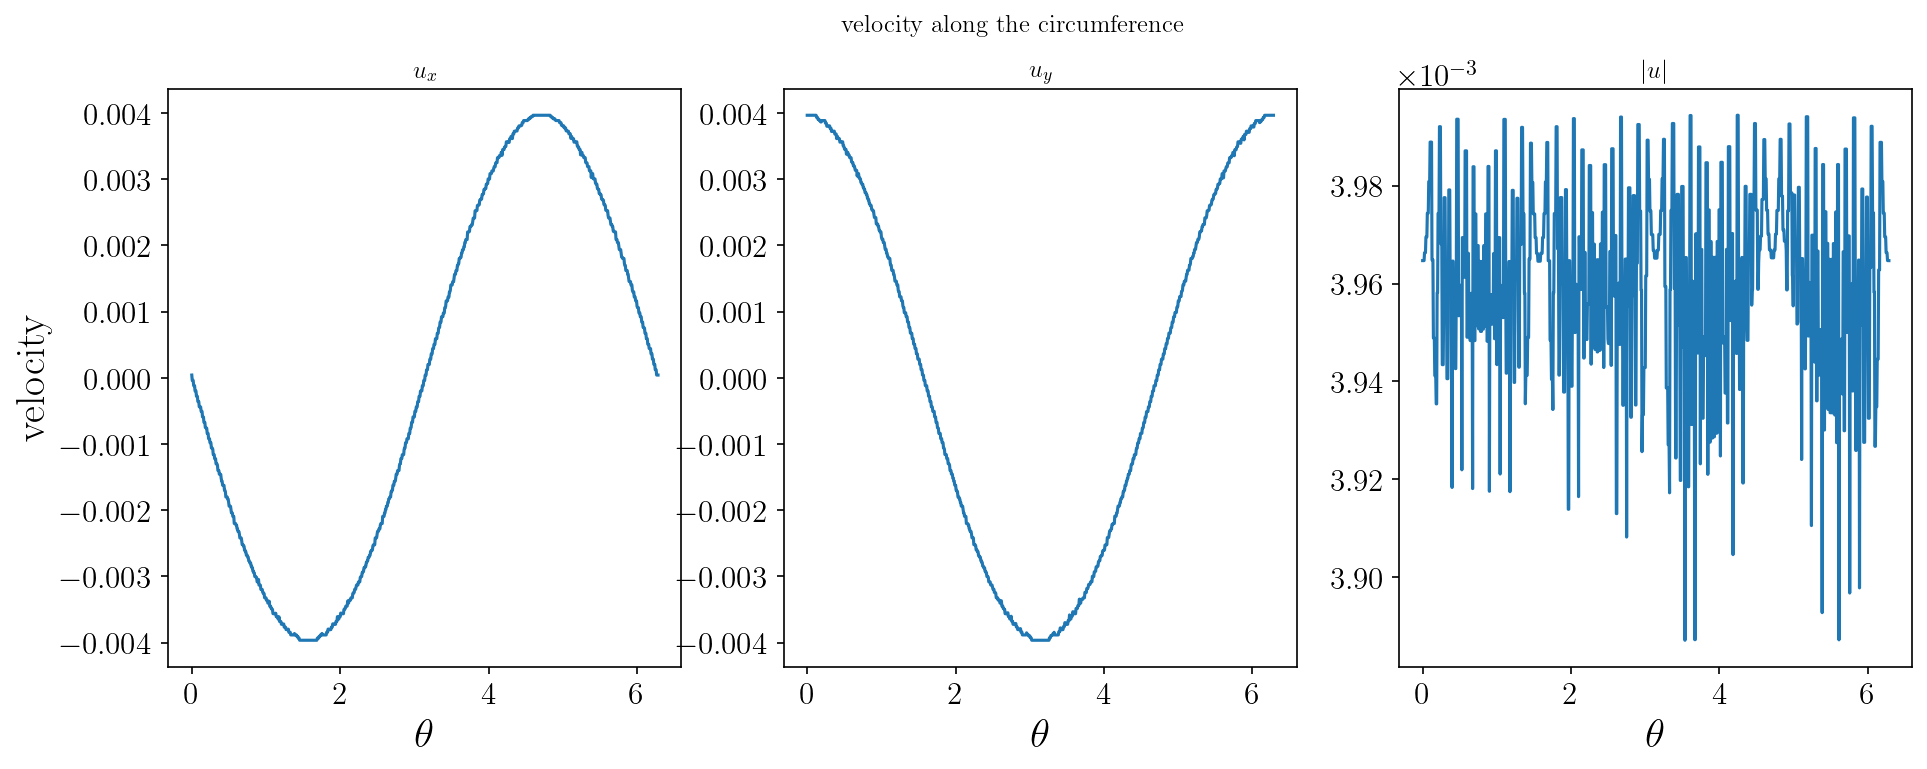

In [14]:
# sanity check
# Extract the corresponding velocities
vel_x = fluidDf['fluidVelocity_x'].values[idx]
vel_y = fluidDf['fluidVelocity_y'].values[idx]

# Compute the magnitude of the vector field
magnitude = np.sqrt(vel_x**2 + vel_y**2)

# setting up stuff
fig, axes = plt.subplots(1,3,figsize = (15,5))

# Add a title for the whole figure
fig.suptitle("velocity along the circumference")

axes[0].plot(theta, vel_x) 
axes[0].set_ylabel("velocity")    
axes[0].set_title("$u_x$")    
axes[1].plot(theta, vel_y) 
axes[1].set_title("$u_y$")    
axes[2].plot(theta, magnitude) 
axes[2].set_title("$|u|$")    

for ax in axes.flatten():
    ax.set_xlabel("$\\theta$")
    ax.yaxis.set_major_formatter(formatter)
#     ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

plt.show()

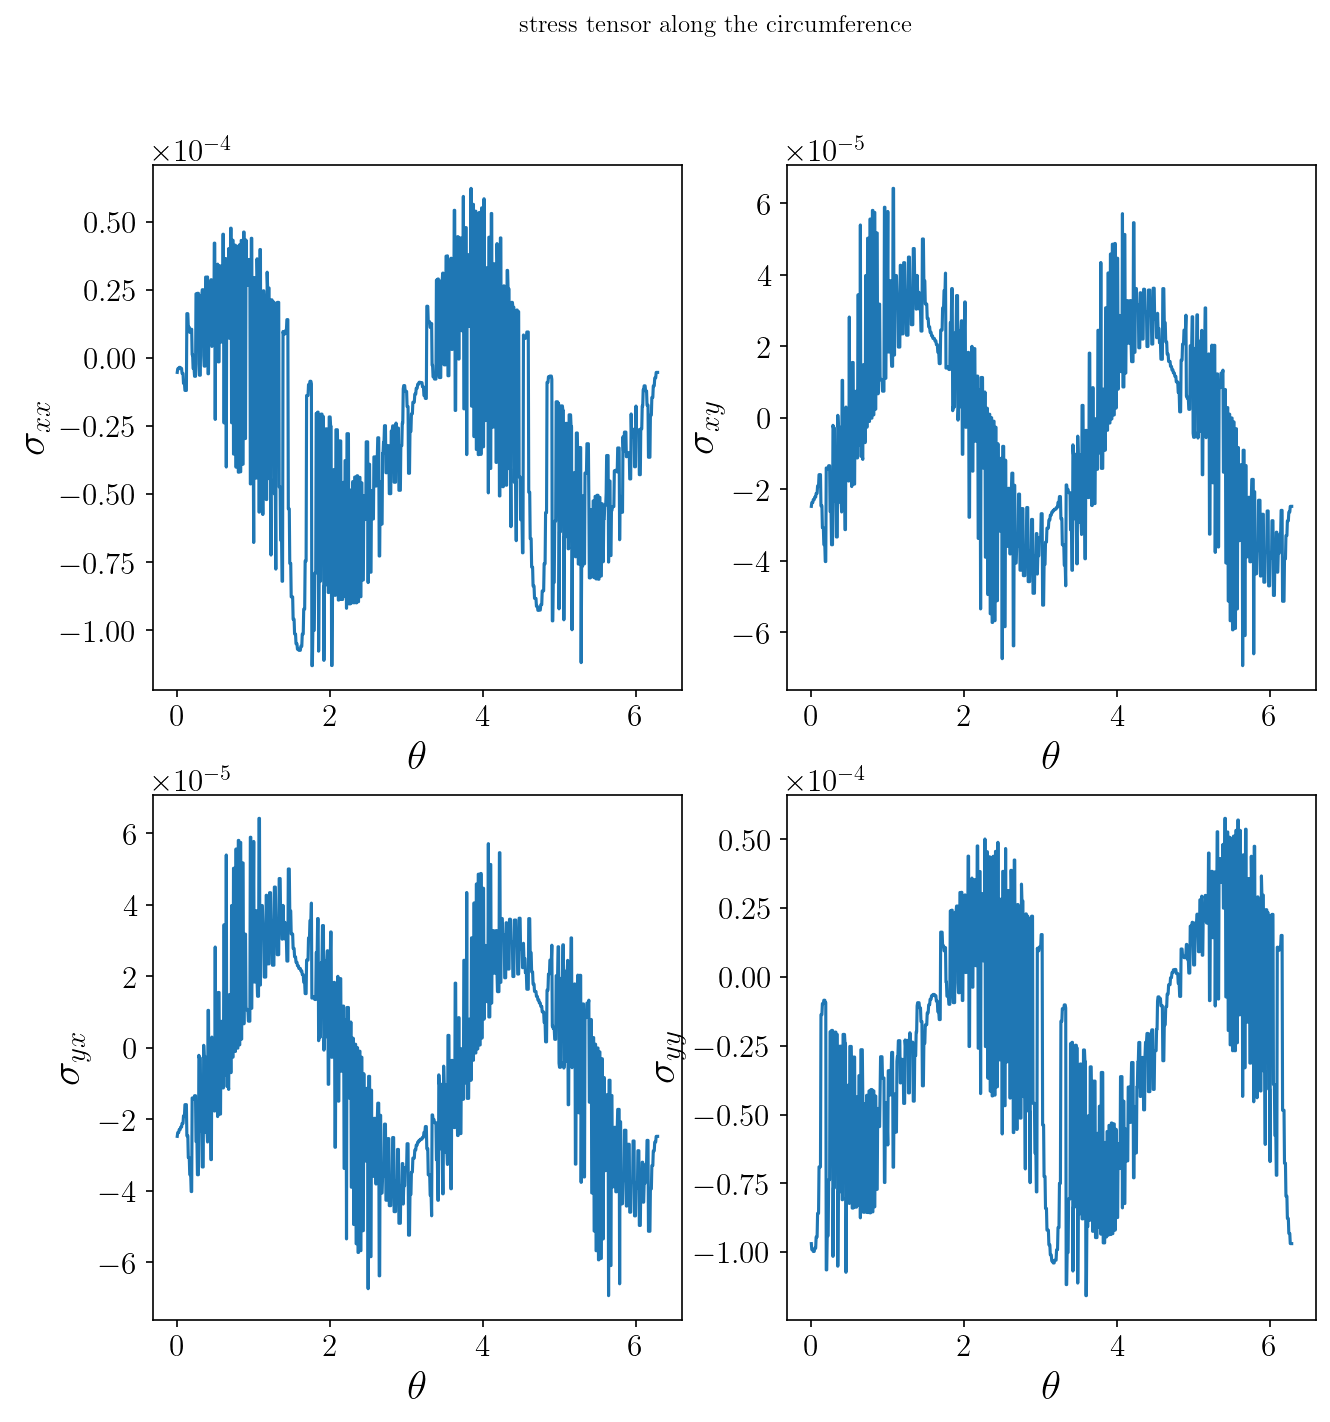

In [15]:
# stress tensor
# Extract the corresponding velocities
sigma_xx = stressDf['component_xx'].values[idx]
sigma_xy = stressDf['component_xy'].values[idx]
sigma_yx = stressDf['component_yx'].values[idx]
sigma_yy = stressDf['component_yy'].values[idx]

# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("stress tensor along the circumference")

axes[0,0].plot(theta, sigma_xx) 
axes[0,0].set_ylabel("$\\sigma_{xx}$")    
axes[0,1].plot(theta, sigma_xy) 
axes[0,1].set_ylabel("$\\sigma_{xy}$")    
axes[1,0].plot(theta, sigma_yx) 
axes[1,0].set_ylabel("$\\sigma_{yx}$")    
axes[1,1].plot(theta, sigma_yy) 
axes[1,1].set_ylabel("$\\sigma_{yy}$")    

for ax in axes.flatten():
    ax.set_xlabel("$\\theta$")
    ax.yaxis.set_major_formatter(formatter)
#     ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

plt.show()

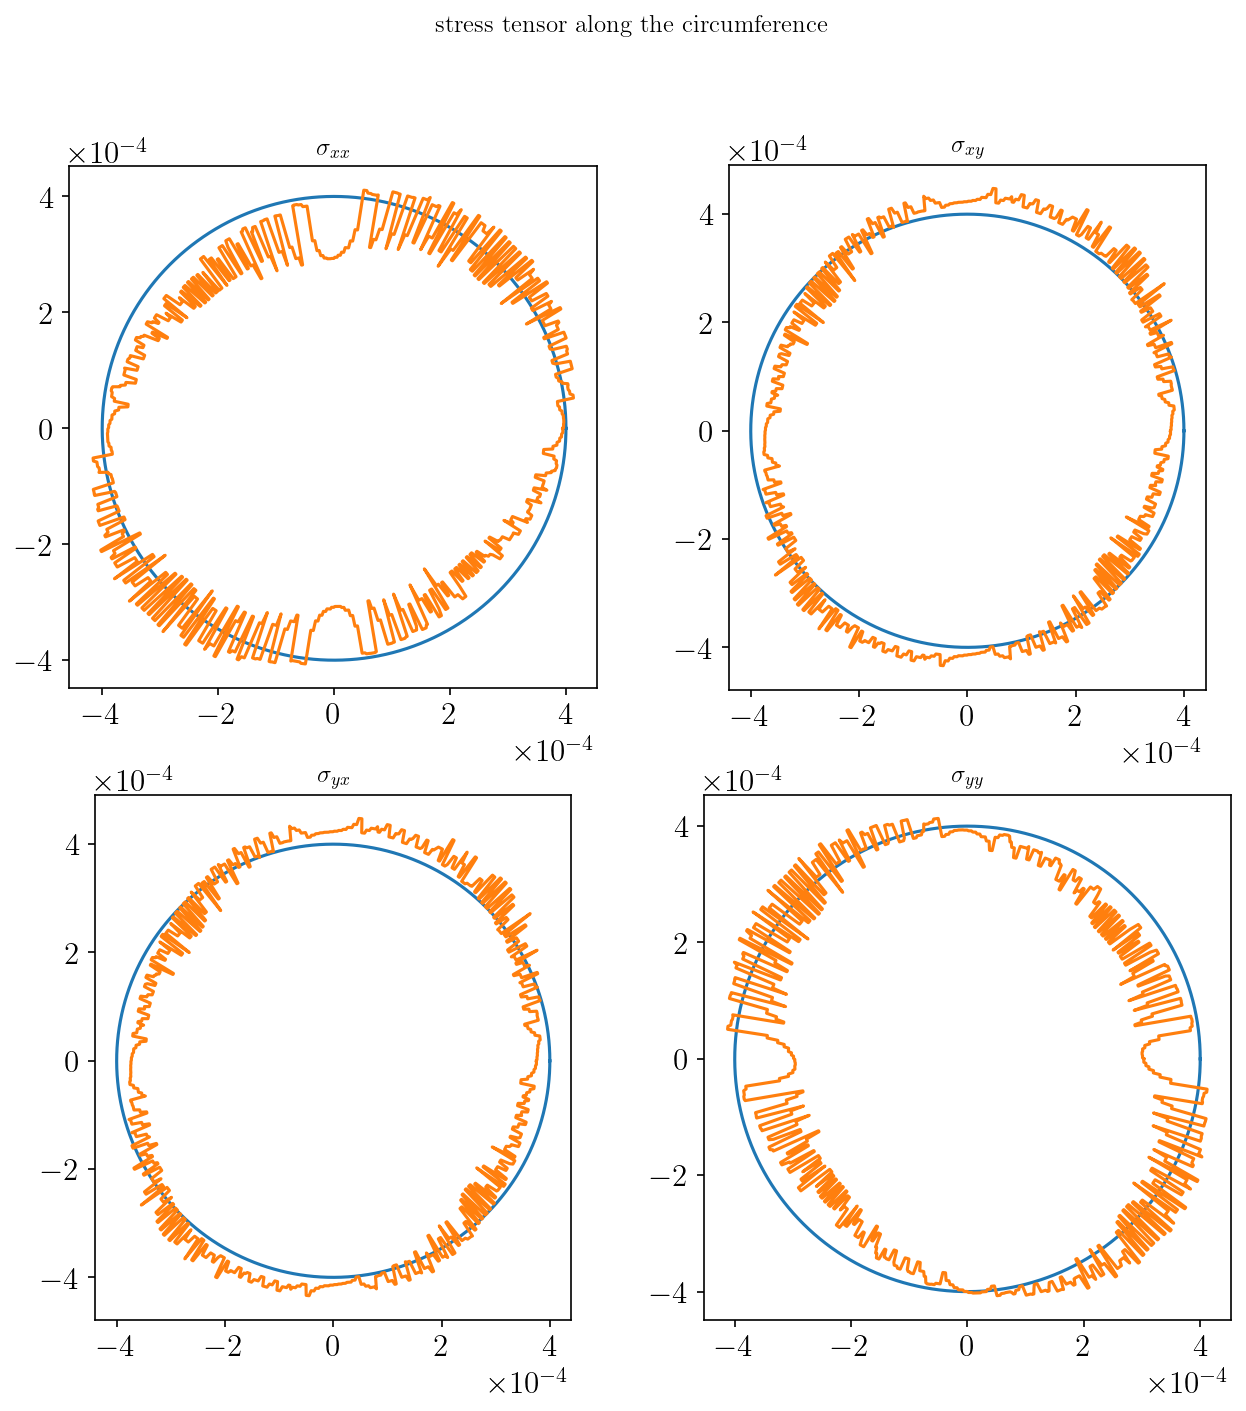

In [16]:
# stress tensor
# Extract the corresponding velocities
sigma_xx = stressDf['component_xx'].values[idx]
sigma_xy = stressDf['component_xy'].values[idx]
sigma_yx = stressDf['component_yx'].values[idx]
sigma_yy = stressDf['component_yy'].values[idx]

baseline = 0.4e-3

# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("stress tensor along the circumference")

axes[0,0].plot((baseline) * np.cos(theta), (baseline) * np.sin(theta)) 
axes[0,0].plot((sigma_xx+baseline) * np.cos(theta), (sigma_xx+baseline) * np.sin(theta)) 
axes[0,0].set_title("$\\sigma_{xx}$")    

axes[0,1].plot((baseline) * np.cos(theta), (baseline) * np.sin(theta)) 
axes[0,1].plot((sigma_xy+baseline) * np.cos(theta), (sigma_xy+baseline) * np.sin(theta)) 
axes[0,1].set_title("$\\sigma_{xy}$")    

axes[1,0].plot((baseline) * np.cos(theta), (baseline) * np.sin(theta)) 
axes[1,0].plot((sigma_yx+baseline) * np.cos(theta), (sigma_yx+baseline) * np.sin(theta)) 
axes[1,0].set_title("$\\sigma_{yx}$")    

axes[1,1].plot((baseline) * np.cos(theta), (baseline) * np.sin(theta)) 
axes[1,1].plot((sigma_yy+baseline) * np.cos(theta), (sigma_yy+baseline) * np.sin(theta)) 
axes[1,1].set_title("$\\sigma_{yy}$")    

for ax in axes.flatten():
#     ax.set_xlabel("$\\theta$")
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_aspect('equal')
#     ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

plt.show()

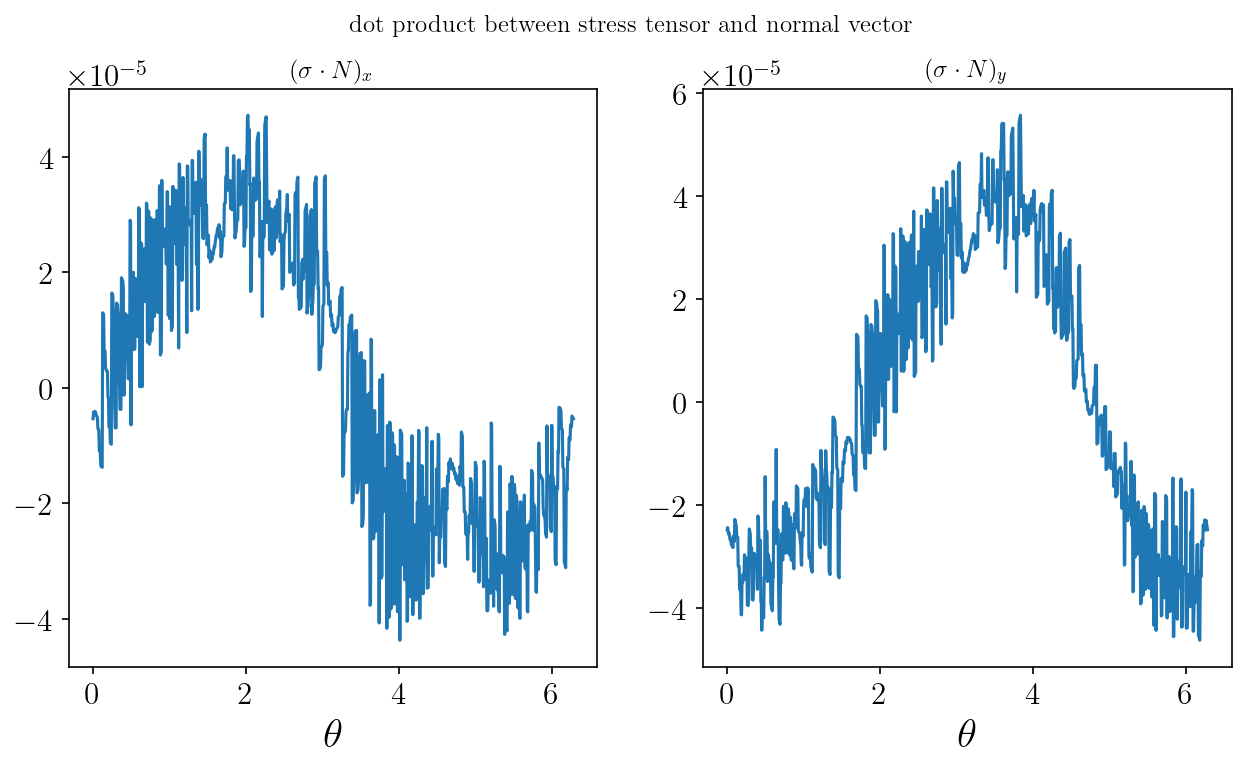

In [17]:
# \sigma_{ij} r_{i}
# R_x = cos(\theta)x 
# R_y = sin(\theta)y
sigmaDotR_x = sigma_xx * np.cos(theta) + sigma_yx * np.sin(theta)
sigmaDotR_y = sigma_xy * np.cos(theta) + sigma_yy * np.sin(theta)

# setting up stuff
fig, axes = plt.subplots(1,2,figsize = (10,5))

# Add a title for the whole figure
fig.suptitle("dot product between stress tensor and normal vector")

axes[0].plot(theta, sigmaDotR_x) 
axes[0].set_title("$(\\sigma \\cdot N)_x$")    
axes[1].plot(theta, sigmaDotR_y) 
axes[1].set_title("$(\\sigma \\cdot N)_y$")    

for ax in axes.flatten():
    ax.set_xlabel("$\\theta$")
    ax.yaxis.set_major_formatter(formatter)
#     ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

plt.show()

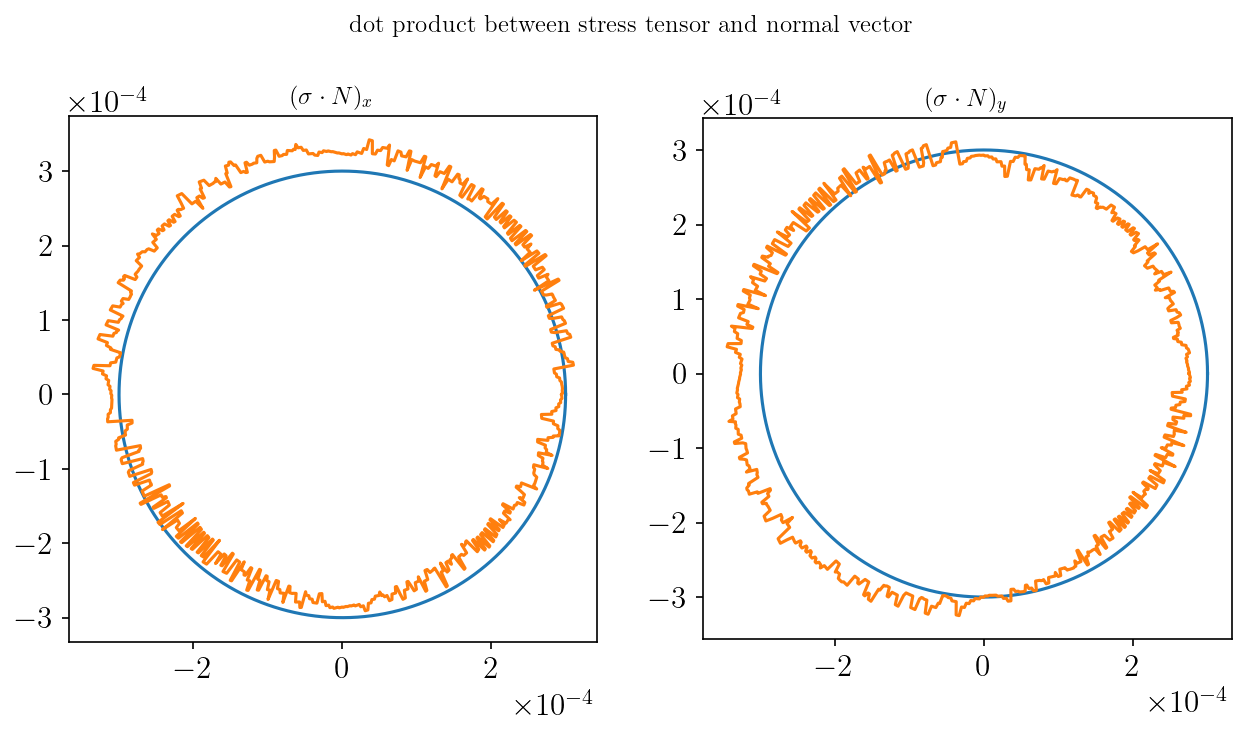

In [18]:
baseline = 3e-4

# setting up stuff
fig, axes = plt.subplots(1,2,figsize = (10,5))

# Add a title for the whole figure
fig.suptitle("dot product between stress tensor and normal vector")

axes[0].plot((baseline) * np.cos(theta), (baseline) * np.sin(theta)) 
axes[0].plot((sigmaDotR_x+baseline) * np.cos(theta), (sigmaDotR_x+baseline) * np.sin(theta)) 
axes[0].set_title("$(\\sigma \\cdot N)_x$")    

axes[1].plot((baseline) * np.cos(theta), (baseline) * np.sin(theta)) 
axes[1].plot((sigmaDotR_y+baseline) * np.cos(theta), (sigmaDotR_y+baseline) * np.sin(theta)) 
axes[1].set_title("$(\\sigma \\cdot N)_y$")    

for ax in axes.flatten():
#     ax.set_xlabel("$\\theta$")
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)
    ax.set_aspect('equal')
#     ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere

plt.show()

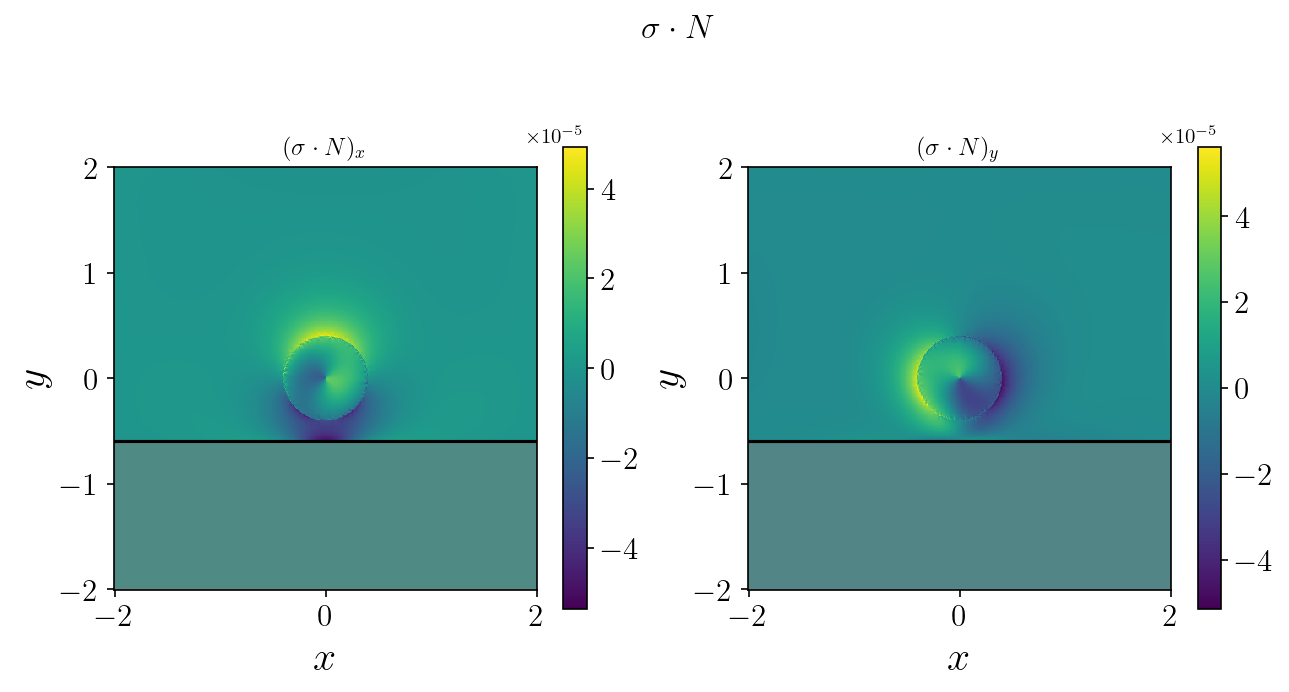

In [19]:
def myInvSqrt(arg):
    sqrtArg = np.sqrt(arg)
    return np.divide(1, sqrtArg, where=(sqrtArg != 0))

# setting up stuff
fig, axes = plt.subplots(1,2,figsize = (10,5))

# Add a title for the whole figure
fig.suptitle("$\\sigma \\cdot N$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0].pcolormesh(X,Y,
    stressDf["component_xx"].unstack().values.transpose() * X * myInvSqrt(X**2 + Y**2)
    + stressDf["component_yx"].unstack().values.transpose() * Y * myInvSqrt(X**2 + Y**2)
); cs.append(c);
axes[0].set_title("$(\\sigma \\cdot N)_x$")

c = axes[1].pcolormesh(X,Y,
    stressDf["component_xy"].unstack().values.transpose() * X * myInvSqrt(X**2 + Y**2)
    + stressDf["component_yy"].unstack().values.transpose() * Y * myInvSqrt(X**2 + Y**2)
); cs.append(c);
axes[1].set_title("$(\\sigma \\cdot N)_y$")

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

# for ax in axes.flat:
for i in range(2):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
    ax.axhline(wallPosition, color = "k")
    ax.axhspan(-2, wallPosition, color='gray', alpha=0.5)  # Shade the wall

plt.show()

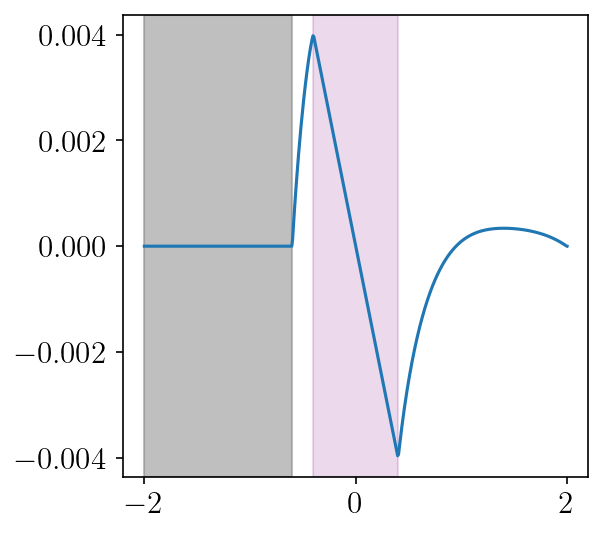

In [20]:
plt.plot(v_x.coordinate_y, v_x.fluidVelocity_x) 
plt.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere
plt.axvspan(-2, wallPosition, color='gray', alpha=0.5)  # Shade the wall

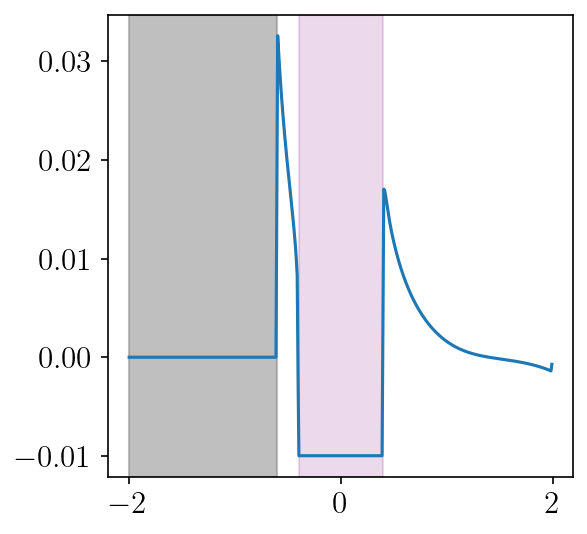

In [21]:
h = v_x.coordinate_y.values[1] - v_x.coordinate_y.values[0]

dvx_dy = [
    (v_x.fluidVelocity_x.values[id + 1] - v_x.fluidVelocity_x.values[id])/h
for id in range(len(v_x.fluidVelocity_x.values)-1)]


plt.plot(v_x.coordinate_y.values[:-1], dvx_dy)
plt.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere
plt.axvspan(-2, wallPosition, color='gray', alpha=0.5)  # Shade the wall

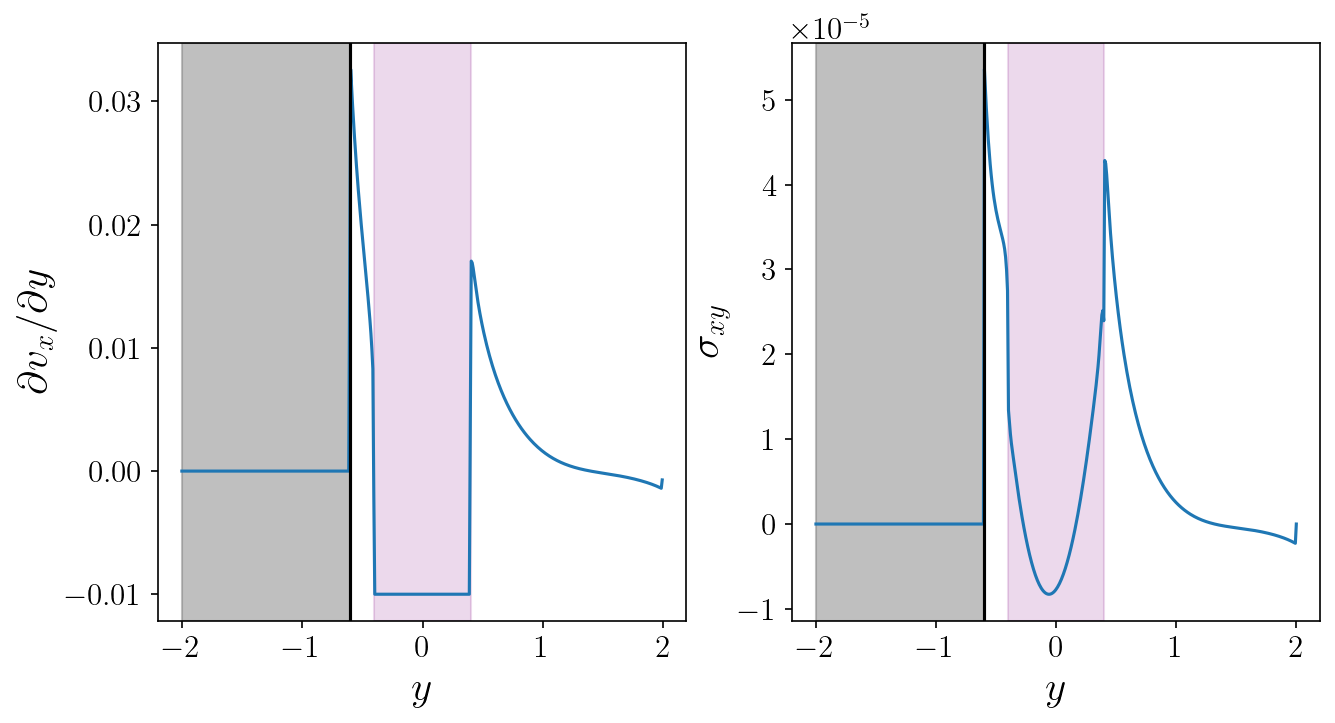

In [22]:
# setting up stuff
fig, axes = plt.subplots(1,2,figsize = (10,5))

axes[0].plot(v_x.coordinate_y.values[:-1], dvx_dy)
axes[0].set_ylabel("$\\partial v_x / \\partial y$")    
axes[1].plot(sigma_x.coordinate_y, sigma_x.component_xy) 
axes[1].set_ylabel("$\\sigma_{xy}$")    
for ax in axes.flatten():
    ax.set_xlabel("$y$")
    ax.yaxis.set_major_formatter(formatter)
    ax.axvline(wallPosition, color = "k")
    ax.axvspan(-2, wallPosition, color='gray', alpha=0.5)  # Shade the wall
    ax.axvspan(-0.4, 0.4, color='purple', alpha=0.15)  # Shade the sphere